In [259]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [260]:
data = pd.read_csv('data/ghana_gdp.csv', parse_dates=['year'], index_col=['year'])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


### Статистические модели прогнозирования.

<AxesSubplot:xlabel='year'>

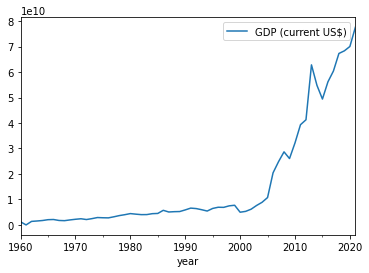

In [261]:
%matplotlib inline 
data.plot()

In [262]:
data.shape

(62, 1)

In [263]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

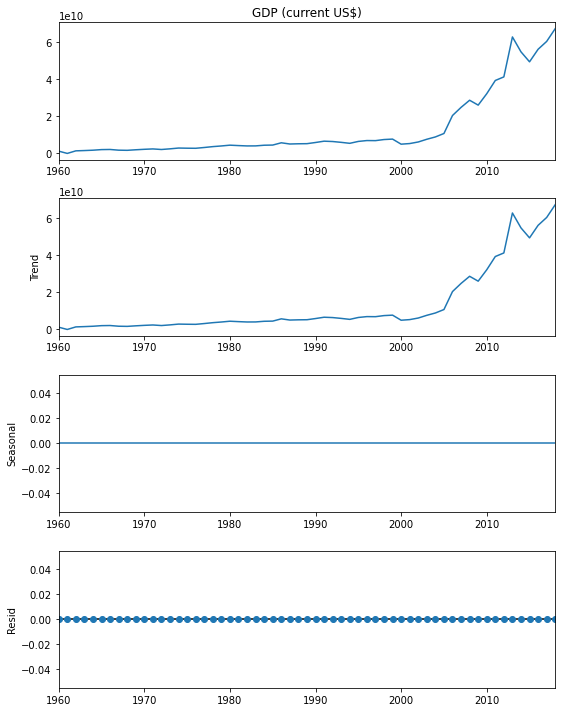

In [264]:
plt.rcParams["figure.figsize"] = 8, 10
result = seasonal_decompose(train_df['GDP (current US$)'], model='additive')
result.plot()
plt.show()

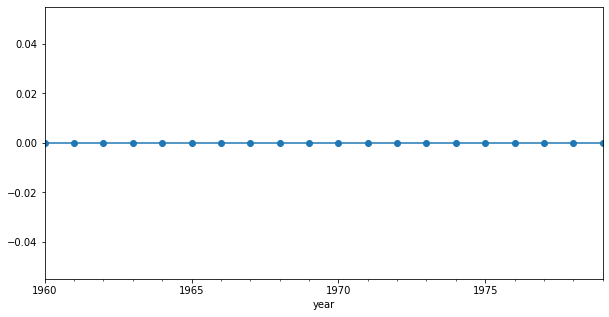

In [265]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker = "o")
plt.show()

По графику видно отсутствие сезонности. При этом отчетливо выражен возрастающий тренд. Данные представлены за каждый год, причем ВВП является макроэкономическим показателем, который не связан с сезонностью, а отражает общее экономическое состояние страны, которое как раз имеет динамику (тренд) роста, падения или стагнации.

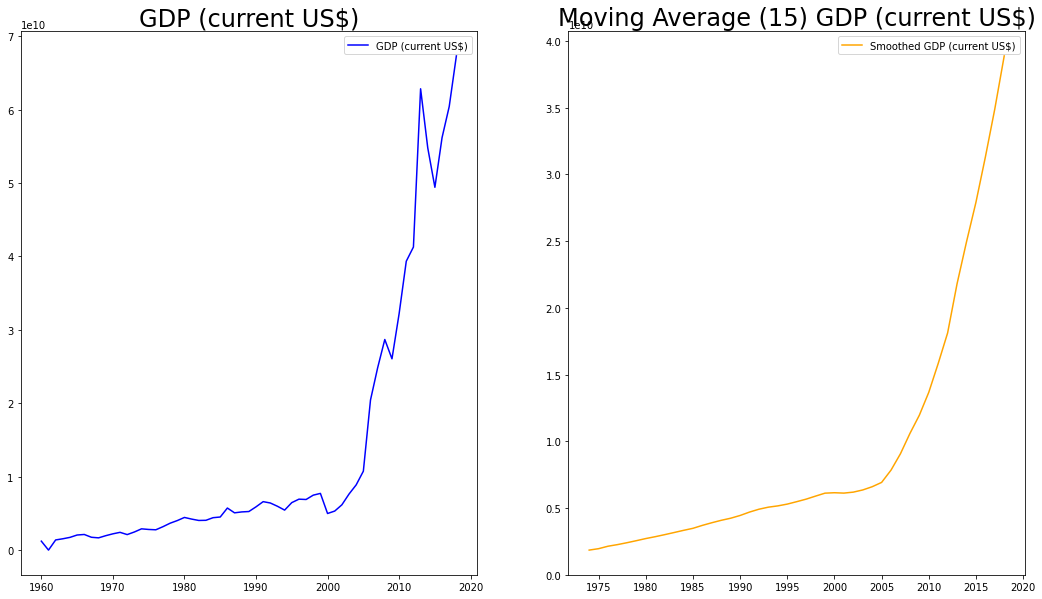

In [266]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(1, 2)

ax[0].plot(train_df['GDP (current US$)'], color = "blue", label = "GDP (current US$)")
ax[0].set_title("GDP (current US$)", size = 24)
ax[0].legend()

ax[1].plot(train_df['GDP (current US$)'].rolling(window=15).mean(), color = "orange", label = "Smoothed GDP (current US$)")
ax[1].set_title("Moving Average (15) GDP (current US$)", size = 24)
ax[1].legend()

На графике выше справа отображена модель скользящего среднего (MA) с шириной окна сглаживания 10 лет. Поскольку скользящее среднее помогает избавить временной ряд от выбросов и лишнего шума, это упрощает визуальный анализ. На графике виден тренд роста ВВП Ганы. Причем до примерно 2000 года темп роста низкий, а после - высокий (кривая резко идет вверх).

In [267]:
test = adfuller(train_df['GDP (current US$)'])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Временной ряд нестационарен')
else:
    print ('Временной ряд стационарен')

adf:  0.6529066974885378
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Временной ряд нестационарен


Так как временной ряд оказался нестационарным, необходимо его дифференцировать до тех пор, пока он не станет стационарным.

In [268]:
test = adfuller(train_df['GDP (current US$)'].diff(2).dropna())
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Временной ряд нестационарен')
else:
    print ('Временной ряд стационарен')

adf:  -3.583670865826036
p-value:  0.006080989753876832
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
Временной ряд стационарен


Так как временной ряд ВВП Ганы нестационарен, то принимаем решение об использовании модели ARIMA.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

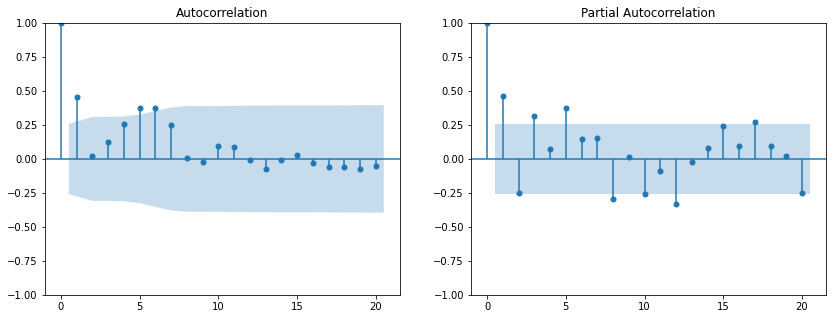

In [269]:
plt.rcParams['figure.figsize'] = 14, 5

fig, axes = plt.subplots(1, 2)
sgt.plot_acf(train_df['GDP (current US$)'].diff(2).dropna(), lags=20, ax=axes[0])
sgt.plot_pacf(train_df['GDP (current US$)'].diff(2).dropna(), lags=20, ax=axes[1])
plt.show

Исходя из графиков автокорреляции и частичной автокорреляции выбираем параметры для модели p=1 и q=1.

In [270]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Fri, 20 Jan 2023   AIC                           2684.416
Time:                        15:39:33   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.95e+56. Standard errors may be unstable.
"""

In [271]:
smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=0,
                         start_P=1, seasonal=False,
                         d=2, D=2, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Fri, 20 Jan 2023   AIC                           2680.765
Time:                        15:39:33   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.54e+55. Standard errors may be unstable.
"""

Наилучшие параметры для модели: ARIMA(1, 2, 3), - для которых коэффициент AIC меньше чем AIC для ARIMA(1, 2, 1) - 2680.765 < 2684.416.

In [272]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramet

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Fri, 20 Jan 2023   AIC                           2680.765
Time:                        15:39:33   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.54e+55. Standard errors may be unstable.
"""

In [273]:
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = arima_model_fit.predict(start = test_df.index[0], end = test_df.index[-1])


pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

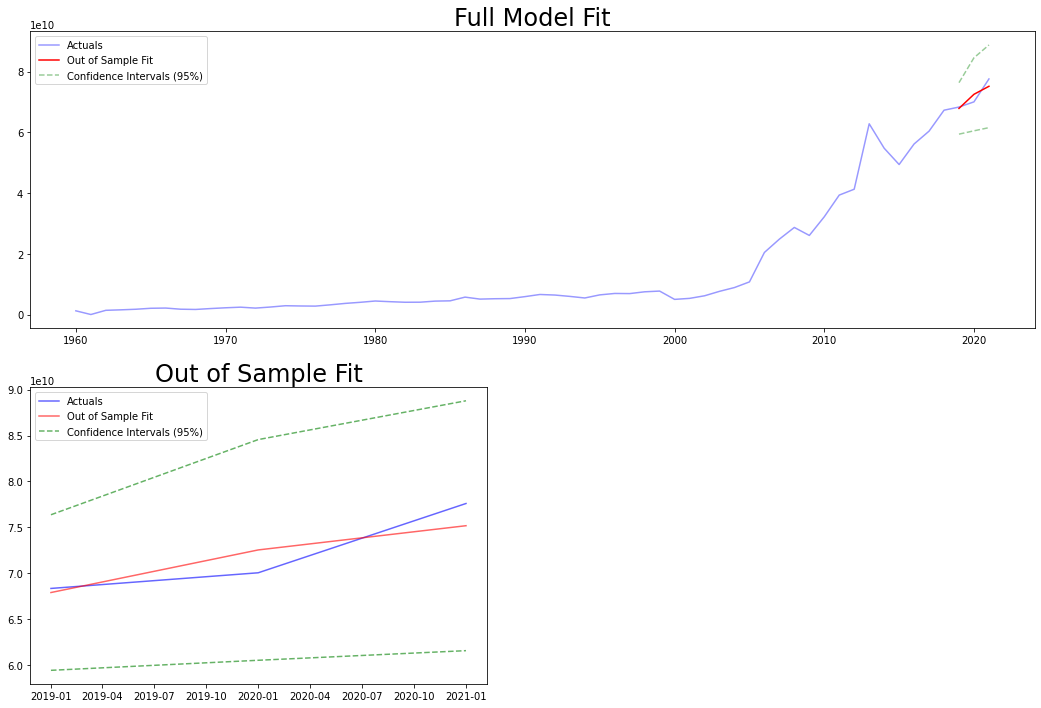

In [274]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["GDP (current US$)"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

Анализируя построенный выше график, можно сделать вывод, что построенная модель ARIMA(1, 2, 3) уловила динамику и тренд временного ряда и довольно близко предсказала значения ВВП Ганы за 2019-2021 годы к истинным значениям. Причем в 2019 году предсказание модели были наиболее близко к фактической величине.

### Интерполяция и сэмплирование.

In [275]:
data_check = data.asfreq(freq='AS')
data_check.isna().sum()

GDP (current US$)    0
dtype: int64

<AxesSubplot:xlabel='year'>

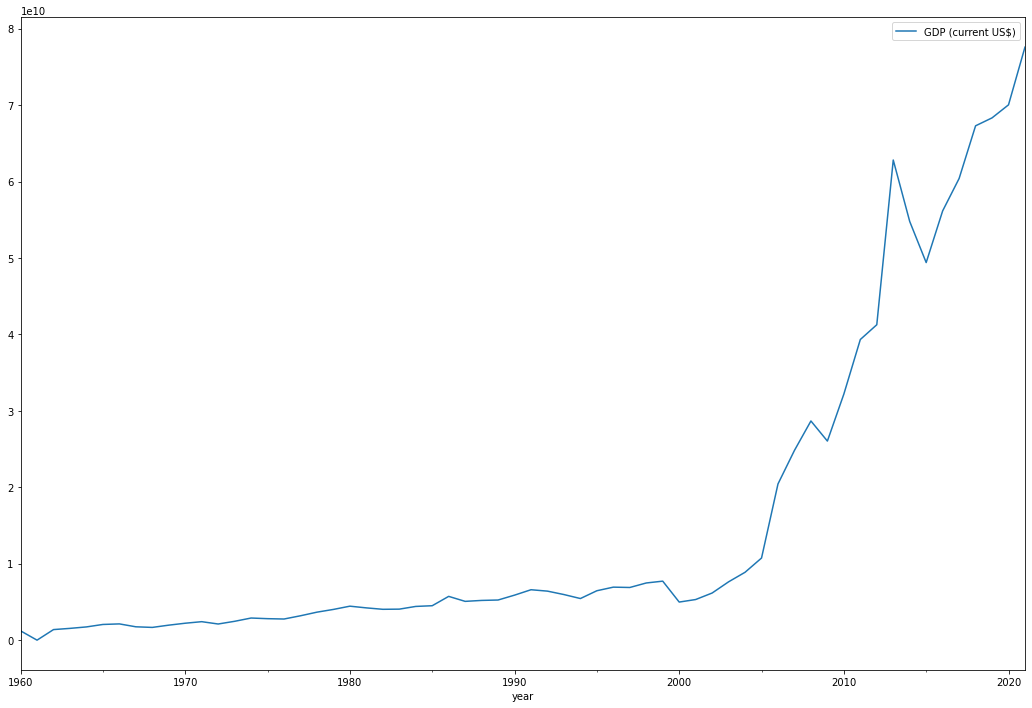

In [276]:
data_check.plot()

Пропущенных дат во временном ряде нет.

In [277]:
data.isna().sum()

GDP (current US$)    0
dtype: int64

Явных пропущенных значений во временном ряде нет.

In [278]:
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [279]:
data.isna().sum()

GDP (current US$)    1
dtype: int64

После заполнения нулей np.Nan был выявлен один пропуск.

In [280]:
data['GDP (current US$)'] = data['GDP (current US$)'].interpolate(method='linear')

In [281]:
data.isna().sum()

GDP (current US$)    0
dtype: int64

Пропущенное значение было заполнено с помощью интерполяции.

In [282]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [283]:
test = adfuller(train_df['GDP (current US$)'])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Временной ряд нестационарен')
else:
    print ('Временной ряд стационарен')

adf:  0.8030073326980119
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Временной ряд нестационарен


Временной ряд нестационарен, следовательно проводим вычетание ряда до состояние стационарности с уровнем альфа 5%.

In [284]:
test = adfuller(train_df['GDP (current US$)'].diff(2).dropna())
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Временной ряд нестационарен')
else:
    print ('Временной ряд стационарен')

adf:  -3.9998034409491567
p-value:  0.0014115408436660881
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
Временной ряд стационарен


Так как временной ряд ВВП Ганы нестационарен, то будет использоваться модель ARIMA.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

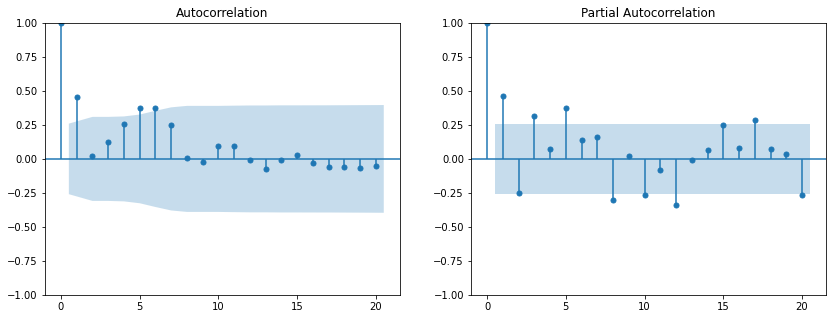

In [285]:
plt.rcParams['figure.figsize'] = 14, 5

fig, axes = plt.subplots(1, 2)
sgt.plot_acf(train_df['GDP (current US$)'].diff(2).dropna(), lags=20, ax=axes[0])
sgt.plot_pacf(train_df['GDP (current US$)'].diff(2).dropna(), lags=20, ax=axes[1])
plt.show

По графикам автокорреляции и частичной автокорреляции определим p=1 и q=1.

In [286]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.188
Date:                Fri, 20 Jan 2023   AIC                           2684.377
Time:                        15:39:34   BIC                           2690.506
Sample:                    01-01-1960   HQIC                          2686.759
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1750      0.082     -2.127      0.033      -0.336      -0.014
ma.L1         -0.8690      0.046    -19.050      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22   9.21e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               277.83
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             480.68   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.01e+57. Standard errors may be unstable.
"""

Подберем наилучшие параметры модели ARIMA.

In [287]:
smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=0,
                         start_P=1, seasonal=False,
                         d=2, D=2, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.00 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.02 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Fri, 20 Jan 2023   AIC                           2680.513
Time:                        15:39:35   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.2e+55. Standard errors may be unstable.
"""

In [288]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramet

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Fri, 20 Jan 2023   AIC                           2680.513
Time:                        15:39:35   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.2e+55. Standard errors may be unstable.
"""

Модель ARIMA на неинтерполированных данных: AIC=2680.765. Модель ARIMA на интерполированных данных: AIC=2680.513. Коэффициент улучшился, но незначительно, что логично, ведь пропущенное значение было только за один год из 62 лет. В остальном временной ряд остался прежним.

Задание 8.3

In [289]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7) # или max_train_size=data['GDP (current US$)'].count()-7
train_test_groups = tscv.split(data['GDP (current US$)']) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


В данном случае было использовано множественное разбиение.

### Модели прогнозирования гетероскедастичности. Валидация временных рядов.

In [290]:
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [291]:
data["GDP_vol"] = data['GDP (current US$)'].pct_change(1).mul(100).abs()
data["GDP_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

<AxesSubplot:xlabel='year'>

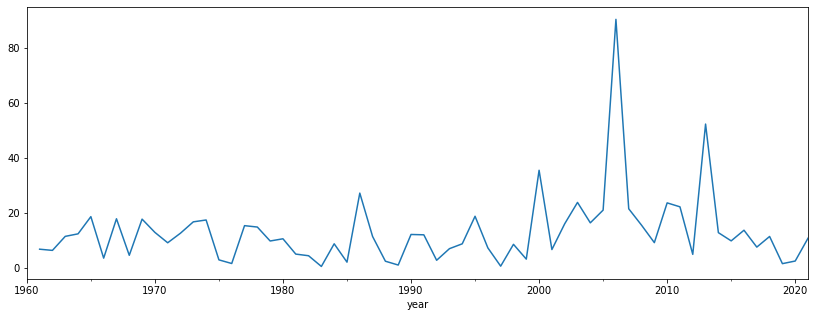

In [292]:
data["GDP_vol"].plot()

In [293]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 2), (3, 2))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


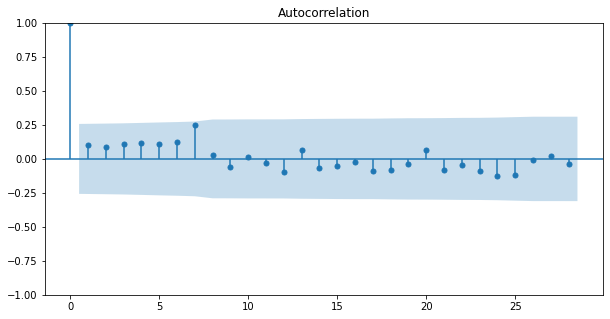

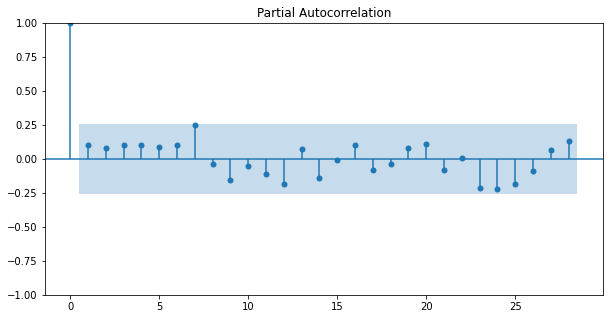

In [294]:
plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_acf(train_df.GDP_vol[1:], lags = 28)
sgt.plot_pacf(train_df.GDP_vol[1:], lags = 28)
plt.show()

In [295]:
test = adfuller(train_df['GDP_vol'][1:])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Временной ряд нестационарен')
else:
    print ('Временной ряд стационарен')

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
Временной ряд стационарен


In [296]:
garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index])
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()
garch_df

,GDP_vol
year,
1960-01-01,NaN
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636
...,...
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746


In [297]:
model = arch_model(garch_df["GDP_vol"].dropna(), p = 6, q = 1, vol = "GARCH")
model_results = model.fit(last_obs = test_df.index[0], update_freq = 5)
model_results.summary()

Iteration:      5,   Func. Count:     59,   Neg. LLF: 220.06777530408098
Iteration:     10,   Func. Count:    113,   Neg. LLF: 214.50075417524232
Iteration:     15,   Func. Count:    164,   Neg. LLF: 214.404074331877
Iteration:     20,   Func. Count:    214,   Neg. LLF: 214.31062290537483
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.31061698140485
            Iterations: 22
            Function evaluations: 233
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.311
Distribution:                  Normal   AIC:                           446.621
Method:            Maximum Likelihood   BIC:                           465.165
                                        No. Observations:                   58
Date:                Fri, Jan 20 2023   Df Residuals:                       57
Time:                        15:39:35   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.2445      1.422      7.910  2.582e-15 [  8.458, 14.031]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         26.5254     29.357      0.904      0.366      [-31.014, 84.065]
alpha[1]   1.3603e-13  1.041e-02  1.306e-11      1.000 [-2.041e-02,2.041e-02]
alpha[2]   2.0450e-12  1.710e-02  1.196e-10      1.000 [-3.351e-02,3.351e-02]
alpha[3]       0.2560      0.754      0.340      0.734      [ -1.222,  1.734]
alpha[4]       0.0000  8.016e-02      0.000      1.000      [ -0.157,  0.157]
alpha[5]   4.5141e-13  1.051e-02  4.294e-11      1.000 [-2.060e-02,2.060e-02]
alpha[6]       0.6731      0.391      1.724  8.477e-02   [-9.229e-02,  1.439]
beta[1]        0.0709  8.247e-02      0.859      0.390   [-9.077e-02,  0.232]
=============================================================================

Covariance estimator: robust
"""

In [298]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [299]:
predictions_df

,GDP (current US$),GDP_vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,114.041433
2020-01-01,7.004320e+10,2.495937,35.991413
2021-01-01,7.759428e+10,10.780603,57.165493


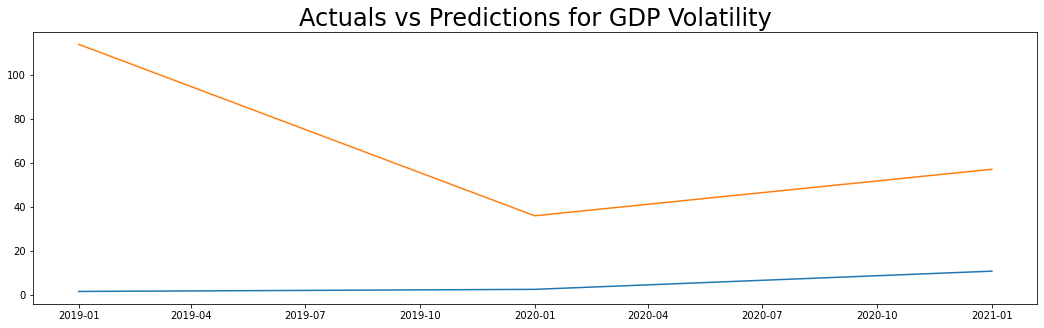

In [300]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size = 24)

plt.show()

In [301]:
np.sqrt(mean_squared_error(predictions_df["GDP_vol"].abs(), predictions_df["Predictions"]))

72.86851056138131

Text(0.5, 1.0, 'Actuals vs Predictions for GDP Volatility')

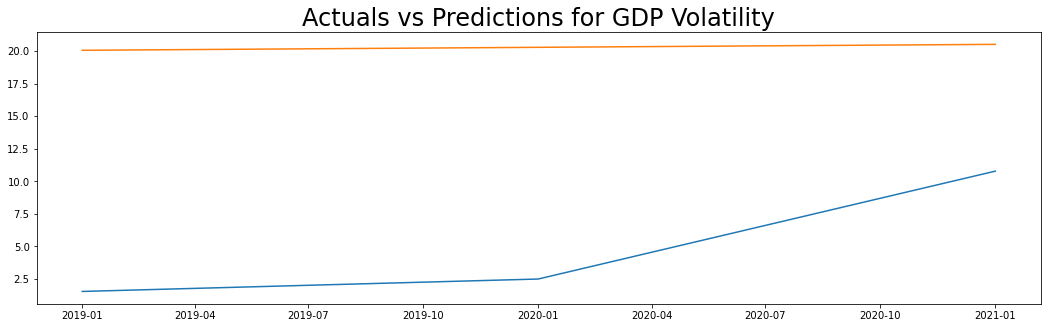

In [302]:
X_train = pd.DataFrame(range(data['GDP_vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['GDP_vol'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['GDP_vol'].fillna(0)
y_test = test_df['GDP_vol'].fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.title("Actuals vs Predictions for GDP Volatility", size = 24)

Анализируя графики предсказания волатильности для GARCH-модели и для линейной регрессии, можно сделать вывод, что обе модели не уловили диспресию: модель линейной регрессии предсказала значения волатильности в районе 20 для 2019-2021 годов, а GARCH-модель предсказала чрезмерно большие значения волатльности, далекие от фактических величин. Итог линейной модели ожидаем, поскольку не был проведен предварительный feature engineering. Но что касается GARCH-модели, то такой результат стал неожиданным.

Тем не менее можно попробовать объяснить плохое предсказание GARCH-модели. Так, модель не уловила дисперсию, потому что поведение тестовой выборки было для неё новым и подобные случаи отсутствовали в обучающей выборке. Можно сказать, что модели не хватило данных для обучения. Чтобы преодолеть данный недостаток, необходимо иметь больше данных в обучающей выборке, которые включали бы в себя случаи возрастания и убывания дисперсии. Кроме того, на плохое прогнозирование мог повлиять большой всплеск диспресии в районе 2005 года.